<a href="https://colab.research.google.com/github/RITIK-12/HAR/blob/main/Notebooks/MLinComm_24GHz_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

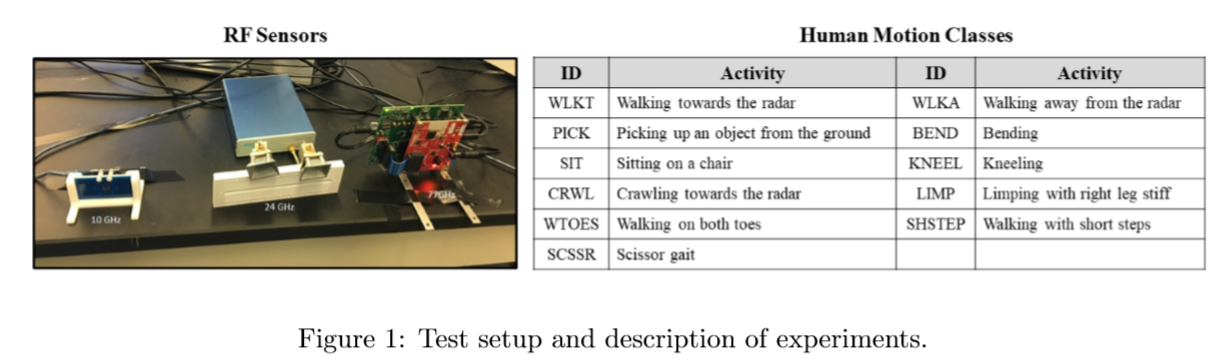

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
data_dir = '/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/Spectrograms_24GHz/'
data_dir = pathlib.Path(data_dir)
train_dir = '/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/Spectrograms_24GHz_split_data/train/'
train_dir = pathlib.Path(train_dir)
test_dir = '/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/Spectrograms_24GHz_split_data/test/'
test_dir = pathlib.Path(test_dir)
valid_dir = '/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/Spectrograms_24GHz_split_data/val/'
valid_dir = pathlib.Path(valid_dir)

In [ ]:
batch_size = 16
img_height = 128
img_width = 128

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 1401 files belonging to 12 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  )

Found 213 files belonging to 12 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 389 files belonging to 12 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['05 walking towards radar', '06 walking away from radar', '07 picking up object', '08 bending', '09 sitting', '10 kneeling', '11 crawling', '12 limping foot drag', '16 walking on toes both', '17 limping with right stiff', '18 short steps', '19 scissors gait']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 128, 128, 3)
(16, 12)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
efnet = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet', input_shape=(128, 128,3),pooling='max')
output = efnet.layers[-1].output
#output = tf.keras.layers.Flatten()(output)
resnet = Model(efnet.input, output)

71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
efnet.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
for layer in resnet.layers:
  set_trainable = True

In [ ]:
num_classes = 12

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()

In [ ]:
filepath = "/content/drive/MyDrive/ITU/models/EfnetB4_20Epochs.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_accuracy", 
    verbose=0, save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 5*1e-12,
                                   )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 1024)              1836032   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                6156      
Total params: 20,040,811
Trainable params: 19,915,604
Non-trainable params: 125,207
______________________________________

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    steps_per_epoch=np.ceil(float(1401)/float(batch_size)), 
    epochs = 20,callbacks= callbacks, 
    validation_steps=np.ceil(float(389)/float(batch_size)), 
    use_multiprocessing= True
    )

Epoch 1/20
88/88 [==============================] - 308s 3s/step - loss: 2.7022 - accuracy: 0.2020 - val_loss: 2.1603 - val_accuracy: 0.2674


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
88/88 [==============================] - 27s 309ms/step - loss: 1.6204 - accuracy: 0.4575 - val_loss: 1.4905 - val_accuracy: 0.4704
Epoch 3/20
88/88 [==============================] - 27s 309ms/step - loss: 1.1072 - accuracy: 0.6124 - val_loss: 1.1299 - val_accuracy: 0.5990
Epoch 4/20
88/88 [==============================] - 27s 313ms/step - loss: 0.7523 - accuracy: 0.7316 - val_loss: 0.9658 - val_accuracy: 0.6632
Epoch 5/20
88/88 [==============================] - 27s 309ms/step - loss: 0.4925 - accuracy: 0.8315 - val_loss: 0.9336 - val_accuracy: 0.7018
Epoch 6/20
88/88 [==============================] - 27s 309ms/step - loss: 0.2941 - accuracy: 0.8972 - val_loss: 1.0193 - val_accuracy: 0.6992
Epoch 7/20
88/88 [==============================] - 27s 308ms/step - loss: 0.1965 - accuracy: 0.9350 - val_loss: 1.1844 - val_accuracy: 0.6915
Epoch 8/20
88/88 [==============================] - 27s 309ms/step - loss: 0.1771 - accuracy: 0.9400 - val_loss: 0.9918 - val_accuracy: 0.7121

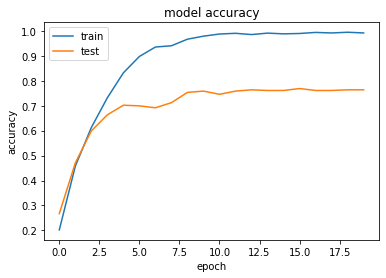

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

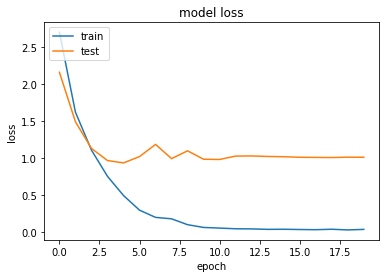

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

14/14 [==============================] - 36s 876ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)
classes = class_names

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

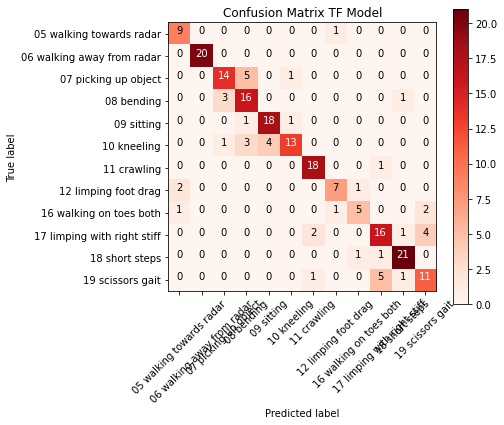

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('cm_wo_norm.png')
plt.show()

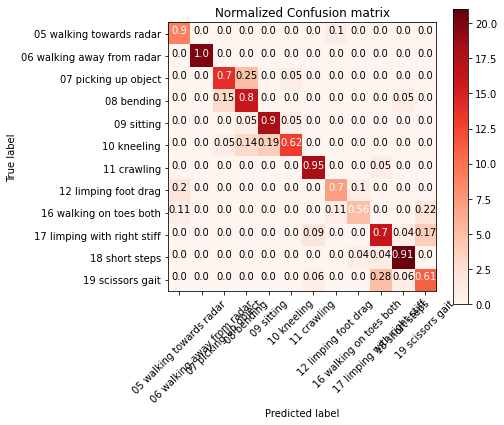

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('cm_norm.jpg')
plt.show()

In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report)

                             precision    recall  f1-score   support

   05 walking towards radar       0.75      0.90      0.82        10
 06 walking away from radar       1.00      1.00      1.00        20
       07 picking up object       0.78      0.70      0.74        20
                 08 bending       0.64      0.80      0.71        20
                 09 sitting       0.82      0.90      0.86        20
                10 kneeling       0.87      0.62      0.72        21
                11 crawling       0.86      0.95      0.90        19
       12 limping foot drag       0.78      0.70      0.74        10
    16 walking on toes both       0.71      0.56      0.63         9
17 limping with right stiff       0.70      0.70      0.70        23
             18 short steps       0.88      0.91      0.89        23
           19 scissors gait       0.65      0.61      0.63        18

                   accuracy                           0.79       213
                  macro avg     